# 4. Support Vector Machines

At the end of this exercise you will know:
- How to train a SVM using Sequential Minimal Optimization (SMO)
- How to train a SVM using Gradient Descent (GD)
- How different SVM Kernels perform

In [9]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler

**Summary of the mathematical formalism**

Soft Margin SVM Lagrangian:

$$
\mathcal{L}(\omega, b, \xi, \alpha, \mu)=\frac{1}{2} \omega^{T} \omega+C \sum_{i=1}^{m} \xi_{i} -\sum_{i=1}^{m} \alpha_{i}\left[y^{(i)}\left(\omega^{\top} x^{(i)}+b\right)-1+\xi_{i}\right]-\sum_{i=1}^{m} \mu_{i} \xi_{i}.
$$

Primal problem:

$$
\min _{\omega, b} \left( \frac{1}{2}\|\omega\|^{2}+C \sum_{i=1}^{m} \xi_{i}\right)
$$

$$
\text{s.t.}\left\{\begin{array}{l}y^{(i)}\left(\omega^{\top} x^{(i)}+b\right) \geq 1-\xi_{i}, \quad i=1, \ldots, m \\ \xi_{i} \ge 0, \quad i=1, \ldots, \mathrm{m}\end{array}\right.
$$

Dual problem:

$$
\max_{\alpha} \left( \sum_{i=1}^{m} \alpha_{i}-\frac{1}{2} \sum_{i,j=1}^{m} y^{(i)} y^{(j)} \alpha_{i} \alpha_{j} K(x^{(i)}, x^{(j)}) \right)
$$

$$
\text { s.t. }\left\{\begin{array}{l}
0 \leq \alpha_{i} \leq C, \quad i=1, \ldots, m \\
\sum_{i=1}^{m} \alpha_{i} y^{(i)}=0
\end{array}\right.
$$

In the dual problem, we have used that $w=\sum_{i=1}^{m} \alpha_{i} y^{(i)} x^{(i)}$ and $\sum_{i=1}^{m} \alpha_{i} y^{(i)}=0$ to get rid of $w$ and $b$. To then find $b$, we use the heuristic $b^* = \frac{1}{m_{\Sigma}} \sum_{j=1}^{m_{\Sigma}}\left(y^{(j)}-\sum_{i=1}^{m_{\Sigma}} \alpha_{i}^{*} y^{(i)}K(x^{(i)}, x^{(j)})\right)$ over the support vectors $m_{\Sigma}$. Note, only in the linear case, the kernel becomes $K(x^{(i)}, x^{(j)}) = \left\langle x^{(i)}, x^{(j)}\right\rangle$. Also note, that only in the dual problem definition we encounter the kernel and can use the kernel trick. 

> Note: for $C \to \infty$ this problem ends up being the Hard Margin SVM.


## 4.1 Artificial Dataset

We use scikit-learn and [`make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) to generate a binary dataset with input features $x\in \mathbb{R}^2$ and labels $y\in \{-1, +1\}$.

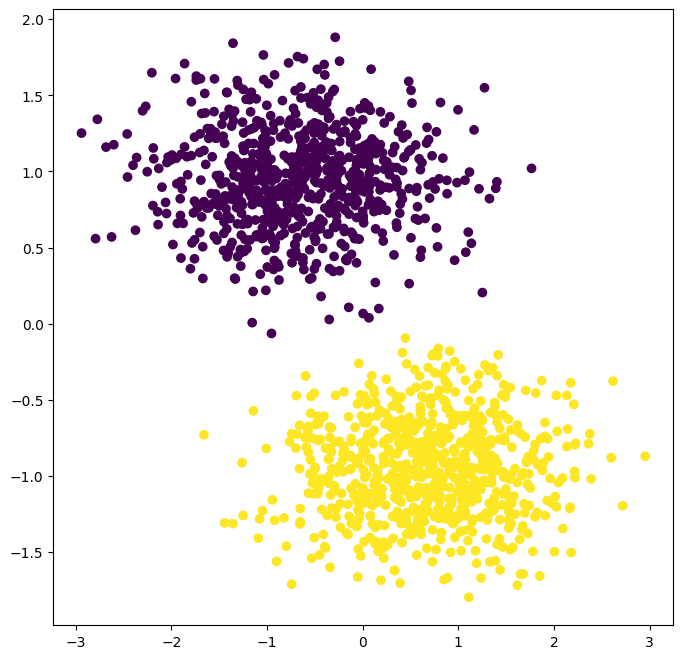

In [80]:
# X as features and Y as labels
X, y = make_blobs(n_samples=1500, centers=2, random_state=0, cluster_std=0.6)
# by default the labels are {0, 1}, so we change them to {-1,1}
y = np.where(y==0, -1, 1)

# we also center the input data (per dimension) and scale it to unit variance to make trainig more efficient
X = (X - X.mean(axis=0))/X.std(axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(x=X[:, 0], y=X[:, 1], c=y)

## 4.2 Sequential Minimal Optimization (SMO)

This algorithm was originally developed by [John Platt in 1998](http://research.microsoft.com/pubs/69644/tr-98-14.pdf) and is optimized for SVM optimization. This algorithm solves the dual problem in a gradient-free manner. It selects two multiplier $\alpha_i$ and $\alpha_j$ and optimizes them while keeping all other $\alpha$s constant. And then itertively repeats the procedure over all $\alpha$s. The efficiency lies in the heuristic used for selecting two $\alpha$ values, which is based on information from previous iterations. In the end we obtain a vector of $M$ values for $\alpha$ corresponding to each training data point, for which most of the $\alpha$ values are $0$ and only the non-zero values contribute to the predictions made by the model.

We adapt the implementation of the SMO algorithm from [this](https://jonchar.net/notebooks/SVM/) reference code by Jon Charest.

**Visualization Utils**

In [30]:
def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
    """Plots the model's decision boundary on the input axes object.
        Range of decision boundary grid is determined by the training data.
        Returns decision boundary grid and axes object (`grid`, `ax`)."""

    # Generate coordinate grid of shape [resolution x resolution]
    # and evaluate the model over the entire space
    xrange = np.linspace(model.X[:, 0].min(), model.X[:, 0].max(), resolution)
    yrange = np.linspace(model.X[:, 1].min(),
                         model.X[:, 1].max(), resolution)
    grid = [[decision_function(model.alphas, model.y,
                               model.kernel, model.X,
                               np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
    grid = np.array(grid).reshape(len(xrange), len(yrange))

    # Plot decision contours using grid and
    # make a scatter plot of training data
    ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
               linestyles=('--', '-', '--'), colors=colors)
    ax.scatter(model.X[:, 0], model.X[:, 1],
               c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.25)

    # Plot support vectors (non-zero alphas)
    # as circled points (linewidth > 0)
    mask = np.round(model.alphas, decimals=2) != 0.0
    ax.scatter(model.X[mask, 0], model.X[mask, 1],
               c=model.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')

    return grid, ax


As a first step, we define a generic SMO model

In [31]:
class SMOModel:
    """Container object for the model used for sequential minimal optimization."""

    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               # training data vector
        self.y = y               # class label vector
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b               # scalar bias term
        self.errors = errors     # error cache used for selection of alphas
        self._obj = []           # record of objective function value
        self.m = len(self.X)     # store size of training set

The next thing we need to define is the kernel. We start with the simplest linear kernel 

$$K(x,x') = x^{\top} x' + b.$$

The implementation of the radial basis function 

$$K(x,x') = \exp \left\{ - \gamma ||x-x'||_2^2 \right\} $$

we leave as an exercise for you.

In [32]:
def linear_kernel(x, y, b=1):
    """Returns the linear combination of arrays `x` and `y` with
    the optional bias term `b` (set to 1 by default)."""

    return x @ y.T + b  # Note the @ operator for matrix multiplication

def gaussian_kernel(x, y, gamma=1):
    """Returns the gaussian similarity of arrays `x` and `y` with
    kernel inverse width parameter `gamma` (set to 1 by default)."""
    
    ######################
    # TODO:
    
    raise NotImplementedError

    #######################

Now, using the dual problem formulation and a `kernel`, we define the objective and decision functions.
The decision function simple imlements $(\omega x + b)$ by using the kernel trick and the relation $w=\sum_{i=1}^{m} \alpha_{i} y^{(i)} x^{(i)}$

In [33]:
# Objective function to optimize, i.e. loss function

def objective_function(alphas, target, kernel, X_train):
    """Returns the SVM objective function based in the input model defined by:
    `alphas`: vector of Lagrange multipliers
    `target`: vector of class labels (-1 or 1) for training data
    `kernel`: kernel function
    `X_train`: training data for model."""

    return np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alphas[:, None] * alphas[None, :]))


# Decision function, i.e. forward model evaluation

def decision_function(alphas, target, kernel, X_train, x_test, b):
    """Applies the SVM decision function to the input feature vectors in `x_test`."""

    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result


**The SMO algorithm**

We are now ready to implement the SMO algorithm as given in Platt's paper. The implementation is split into three functions: `take_step`, `examine_example`, and `train`.
- `train` is the main training loop and also implements the selection of the first of the two $\alpha$ values.
- `examine_example` implements the selection of the second $\alpha$ value
- `take_step` optimizes the two $\alpha$ values, the bias $b$, and the cache.

In [34]:
def take_step(i1, i2, model):

    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model

    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2

    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22

    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H

    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2

    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C

    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model

    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)

    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b

    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2

    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0

    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
        y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
        y2*(a2 - alph2) * \
        model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new

    # Update model threshold
    model.b = b_new

    return 1, model


In [35]:
def examine_example(i2, model):

    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):

        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

    return 0, model


In [36]:
def train(model):

    numChanged = 0
    examineAll = 1 # loop over each alpha in first round

    while (numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(
                        model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(
                        model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1

    return model


We are now ready to define the model (after defining some hyperparameters).

In [43]:
# Set model parameters and initial values
C = 1000.0
m = len(X)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01  # error tolerance
eps = 0.01  # alpha tolerance

# Instantiate model
model = SMOModel(
    X, y, C, 
    kernel=linear_kernel,
    alphas=initial_alphas,
    b=initial_b,
    errors= np.zeros(m)
)

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

/tmp/ipykernel_37058/1098051293.py:18: UserWarning: No contour levels were found within the data range.
  ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),


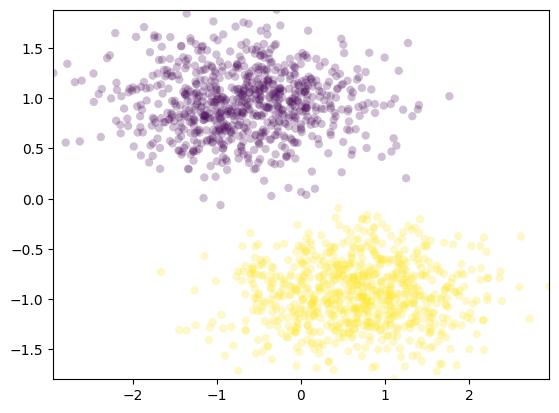

In [40]:
# show initial performance
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)

In [51]:
np.random.seed(0)
output = train(model)

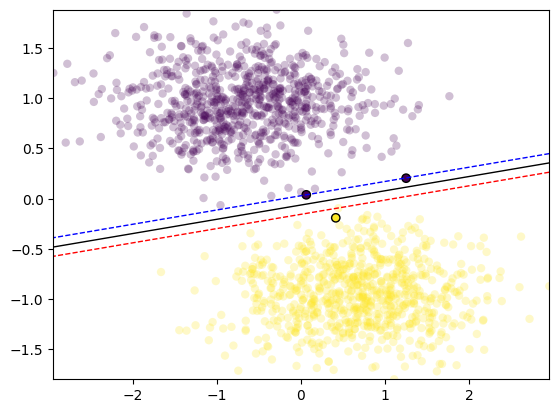

In [53]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

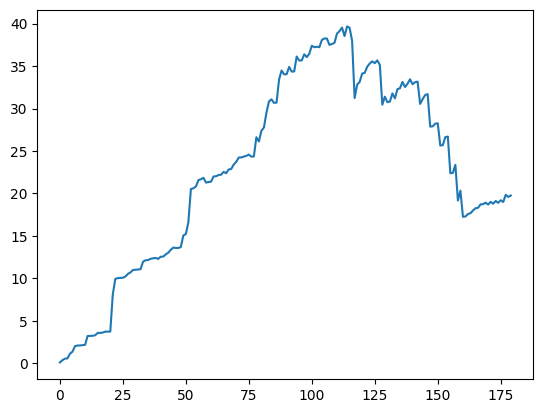

In [55]:
# loss curve
# note: we started with all alphas = 0 and turned some of them on one by one, and then refined.

plt.plot(model._obj)

## 4.3 Gradient Descent Optimization

We can also directly solve the primal problem with gradient-based optimization, if we slightly reformulate it. This reformulation requires using the hinge loss $\max(0, y_{pred}-1)$

**Visualization Utils**

In [81]:
def visualize_torch(X, Y, w=None, b=None, model=False):
    """
    based on 
    https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html#sphx-glr-auto-examples-svm-plot-svm-margin-py
    """

    if model:
        assert w == None and b == None, "Either w, b or model can be provided"
        w = model.weight.squeeze().detach().numpy()
        b = model.bias.squeeze().detach().numpy()

    # extend bounds by 0.1 to improve the plot
    x_min = X[:, 0].min() - 0.1
    x_max = X[:, 0].max() + 0.1

    # solving $w0+x1 + w1*x2 + b = 0$ for $x2$ leads to $x2 = -w0/w1 - b/w1$
    a = -w[0] / w[1]
    xx = np.linspace(x_min, x_max, 50)
    yy = a * xx - b / w[1]

    # $margin = 1 / ||w||_2$
    # Why? Recall that the distance between a point (x_p, y_P) and a line
    # $ax+by+c=0$ is given by $|ax_p+by_p+c|/\sqrt{a^2+b^2}$. As we set the
    # functional margin to 1, i.e. $|ax_i+by_i+c|=1$ for a support vector
    # point, then the total margin becomes $1 / ||w||_2$.
    margin = 1 / np.sqrt(np.sum(w**2))
    yy_up = yy + np.sqrt(1+a**2) * margin
    yy_down = yy - np.sqrt(1+a**2) * margin

    plt.figure(figsize=(10, 10))
    plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, s=10)
    plt.plot(xx, yy, "k-")
    plt.plot(xx, yy_up, "r--")
    plt.plot(xx, yy_down, "b--")
    plt.tight_layout()
    plt.show()


Let's first look at the case of a linear kernel.

In [89]:
class SupportVectorMachine(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Linear(2, 1)

    def forward(self, x):
        return self.model(x)


Some preparation before we train the model

In [90]:
# prepare the data
X = torch.Tensor(X)
Y = torch.Tensor(y)
N = len(Y)

In [91]:
# set hyperparameters
learning_rate = 0.01
epoch = 500
batch_size = 10

# initialize model
model = SupportVectorMachine()
# define hinge loss
criterion = lambda out, y: torch.mean(torch.clamp(1 - out * y, min=0))
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
model.train()

# print initial parameters
for name, param in model.named_parameters():
  print(name, ": ", param.data)


model.weight :  tensor([[-0.0933, -0.4716]])
model.bias :  tensor([-0.3917])


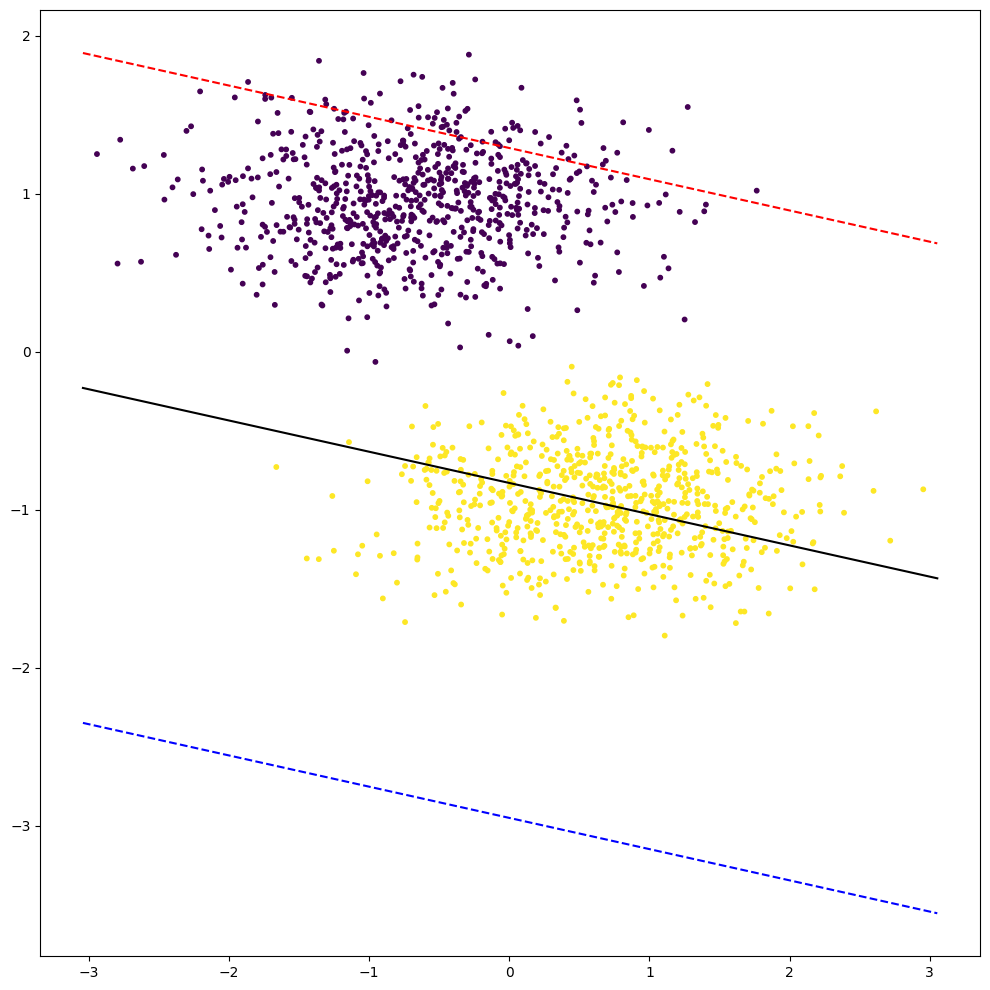

In [92]:
# visualize decision boundary and margins before training
visualize_torch(X, Y, model=model.model)

Now, we train the model

In [93]:
for epoch in range(epoch):
    random_nums = torch.randperm(N)

    # Iterate over the individual batches
    for i in range(0, N, batch_size):
        x = X[random_nums[i:i + batch_size]]
        y = Y[random_nums[i:i + batch_size]]

        x = Variable(x)
        y = Variable(y)

        optimizer.zero_grad()
        output = model(x)

        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))


epoch 0, loss 1.0
epoch 1, loss 1.037710428237915
epoch 2, loss 0.6296830177307129
epoch 3, loss 1.0113270282745361
epoch 4, loss 0.9945489764213562
epoch 5, loss 0.9861934185028076
epoch 6, loss 0.9714006185531616
epoch 7, loss 0.9780317544937134
epoch 8, loss 0.9693995118141174
epoch 9, loss 0.8684085011482239
epoch 10, loss 1.0023398399353027
epoch 11, loss 1.01217782497406
epoch 12, loss 0.949317991733551
epoch 13, loss 0.9097648859024048
epoch 14, loss 1.0
epoch 15, loss 1.0052322149276733
epoch 16, loss 0.998340368270874
epoch 17, loss 0.9999999403953552
epoch 18, loss 0.9599748253822327
epoch 19, loss 1.0006119012832642
epoch 20, loss 1.0211067199707031
epoch 21, loss 0.9878845810890198
epoch 22, loss 1.0
epoch 23, loss 0.9629693627357483
epoch 24, loss 0.897744357585907
epoch 25, loss 0.9095276594161987
epoch 26, loss 0.9665170311927795
epoch 27, loss 1.0085572004318237
epoch 28, loss 0.9593522548675537
epoch 29, loss 0.986879289150238
epoch 30, loss 1.0107148885726929
epoch 31

In [94]:
# print final parameters
for name, param in model.named_parameters():
  print(name, ": ", param.data)


model.weight :  tensor([[ 0.0682, -0.7003]])
model.bias :  tensor([0.0114])


In this formulation all samples are used to fit the parameters. This in contranst to the SMO solution might take longer to optimize, but is more stable because we don't select individial samples and ignore all the others.

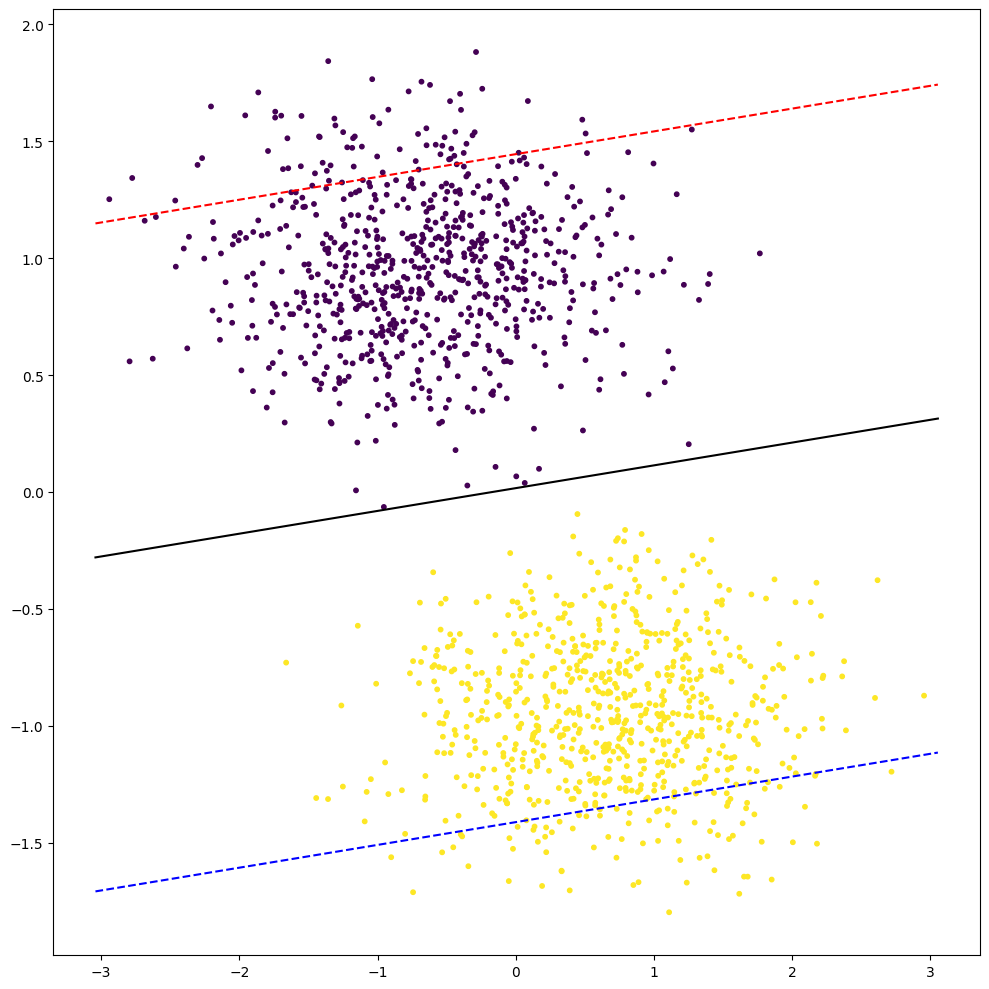

In [95]:
visualize_torch(X, Y, model=model.model)

**Exercise**

Implement the Radial Basis Function (RBF) kernel.

In [ ]:
###########
# TODO: 


###########